### Clean Model Classifier on Jarlids Dataset + Heatmap Implementation 
#### By: Madison Mina
Now that we have SAM2 working, let's start on partitioning each lid to its own image so we can run the cnn classifier model from the casting dataset on the jarlids! With this model, we can run Grad-Cam, aka HEATMAPS!!!

In [1]:
# Going to my jarlids folder
%cd /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4

/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4


In [2]:
import os
import json
import pandas as pd
from PIL import Image

# Loading the dataset
df = pd.read_csv("jarlids_annots.csv")

# Making output directories
base_out = "jarlids_crops"
damaged_dir = os.path.join(base_out, "damaged")
intact_dir  = os.path.join(base_out, "intact")

os.makedirs(damaged_dir, exist_ok=True)
os.makedirs(intact_dir, exist_ok=True)

# Crop counter to avoid filename collisions
crop_id = 0

# Group by filename (each jar lid image)
for filename, group in df.groupby("filename"):

    # Load the original image
    img = Image.open(filename).convert("RGB")

    # Loop through every region/bounding box in that image
    for _, row in group.iterrows():

        shape = json.loads(row["region_shape_attributes"])
        label = json.loads(row["region_attributes"])

        if shape["name"] != "rect":
            continue

        # Bounding box coordinates
        x = shape["x"]
        y = shape["y"]
        w = shape["width"]
        h = shape["height"]

        bbox = (x, y, x + w, y + h)

        # Crop the region
        crop = img.crop(bbox)

        # Choose save directory
        if label["type"] == "damaged":
            out_dir = damaged_dir
        else:
            out_dir = intact_dir

        # Save crop
        out_path = os.path.join(out_dir, f"crop_{crop_id}.jpg")
        crop.save(out_path)
        crop_id += 1

        print(f"Saved {out_path}")

print("✔ All lid crops saved into:", base_out)

Saved jarlids_crops/intact/crop_0.jpg
Saved jarlids_crops/intact/crop_1.jpg
Saved jarlids_crops/damaged/crop_2.jpg
Saved jarlids_crops/intact/crop_3.jpg
Saved jarlids_crops/intact/crop_4.jpg
Saved jarlids_crops/intact/crop_5.jpg
Saved jarlids_crops/intact/crop_6.jpg
Saved jarlids_crops/intact/crop_7.jpg
Saved jarlids_crops/intact/crop_8.jpg
Saved jarlids_crops/intact/crop_9.jpg
Saved jarlids_crops/intact/crop_10.jpg
Saved jarlids_crops/damaged/crop_11.jpg
Saved jarlids_crops/damaged/crop_12.jpg
Saved jarlids_crops/intact/crop_13.jpg
Saved jarlids_crops/intact/crop_14.jpg
Saved jarlids_crops/damaged/crop_15.jpg
Saved jarlids_crops/damaged/crop_16.jpg
Saved jarlids_crops/intact/crop_17.jpg
Saved jarlids_crops/damaged/crop_18.jpg
Saved jarlids_crops/damaged/crop_19.jpg
Saved jarlids_crops/intact/crop_20.jpg
Saved jarlids_crops/damaged/crop_21.jpg
Saved jarlids_crops/damaged/crop_22.jpg
Saved jarlids_crops/damaged/crop_23.jpg
Saved jarlids_crops/intact/crop_24.jpg
Saved jarlids_crops/damag

Great! So now we have a separate image per each jarlid (similar to the casting dataset)

Lets look at one intact and one damaged lid!

Intact Jarlid:


(-0.5, 119.5, 111.5, -0.5)

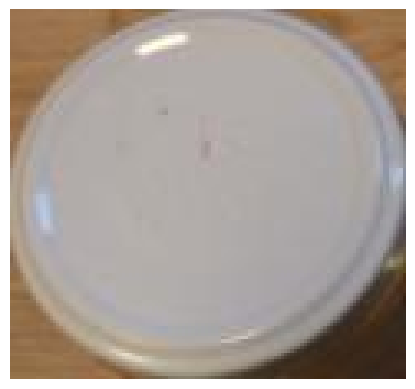

In [3]:
import matplotlib.pyplot as plt
img = Image.open("jarlids_crops/intact/crop_0.jpg")
print("Intact Jarlid:")
plt.imshow(img)
plt.axis("off")

Damaged Jarlid:


(-0.5, 143.5, 119.5, -0.5)

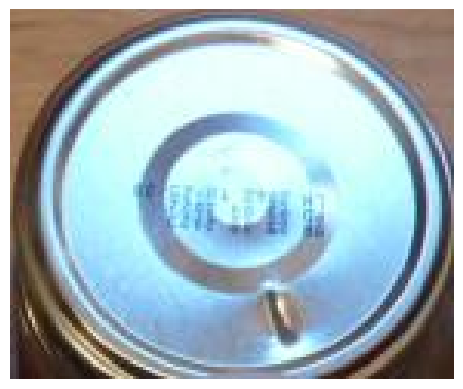

In [4]:
img = Image.open("jarlids_crops/damaged/crop_2.jpg")
print("Damaged Jarlid:")
plt.imshow(img)
plt.axis("off")

Awesomeness... Let's now train on the damaged single lid subset :D This is to show that our classifier model can be transferable to any dataset :)

In [5]:
# Splitting the data into training and testing folders
import random
import shutil

base_dir = "jarlids_crops"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

classes = ["damaged", "intact"]

# Create folder structure
for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

for cls in classes:
    src_folder = os.path.join(base_dir, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    test_size = int(0.2 * len(images))  # 20% test

    test_images = images[:test_size]
    train_images = images[test_size:]

    # Move train images
    for img in train_images:
        shutil.copy(
            os.path.join(src_folder, img),
            os.path.join(train_dir, cls, img)
        )

    # Move test images
    for img in test_images:
        shutil.copy(
            os.path.join(src_folder, img),
            os.path.join(test_dir, cls, img)
        )

    print(f"{cls}: {len(train_images)} train, {len(test_images)} test")

print("✔ Dataset split complete!")


damaged: 718 train, 179 test
intact: 770 train, 192 test
✔ Dataset split complete!


In [6]:
trainset = "jarlids_crops/train"
testset = "jarlids_crops/test"

In [7]:
# Going back to jupyter notebook directory to access the model
%cd /home/ad.msoe.edu/minam 

/home/ad.msoe.edu/minam


In [8]:
%run Clean_Model.ipynb

2025-12-05 14:40:35.311668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 14:40:35.384487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 14:40:39.500701: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/miniforge/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: Tq

Found 5971 images belonging to 2 classes.


I0000 00:00:1764963643.508826 1229859 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:60:00.0, compute capability: 7.5
I0000 00:00:1764963643.510716 1229859 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13759 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5
I0000 00:00:1764963643.512475 1229859 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13759 MB memory:  -> device: 2, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5
I0000 00:00:1764963643.514296 1229859 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13759 MB memory:  -> device: 3, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5
2025-12-05 14:41:16.627165: I external/local_xla/xla/service/service.cc:163] XLA service 0x7bb954002330 initialized 

185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

2025-12-05 14:41:36.983705: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 14:41:37.121395: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8809 - loss: 0.2783 - val_accuracy: 0.9783 - val_loss: 0.0789
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9725 - loss: 0.0819 - val_accuracy: 0.9950 - val_loss: 0.0290
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9842 - loss: 0.0521 - val_accuracy: 0.9933 - val_loss: 0.0302
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9860 - loss: 0.0427 - val_accuracy: 0.9967 - val_loss: 0.0191
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9899 - loss: 0.0322 - val_accuracy: 0.9849 - val_loss: 0.0447
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9903 - loss: 0.0339 - val_accuracy: 0.9933 - val_loss: 0.0191
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0392 - val_accuracy: 0.9950 - val_loss: 0.0194
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accura

2025-12-05 14:42:00.099228: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 14:42:00.236731: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9916 - loss: 0.0328
Test accuracy: 0.9916083812713623


2025-12-05 14:42:07.719416: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 14:42:07.854188: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


CPU times: user 97.3 ms, sys: 75.1 ms, total: 172 ms
Wall time: 170 ms


In [9]:
%cd /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4

/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4


In [10]:
detector = DefectDetector(trainset)

Found 1658 images belonging to 2 classes.
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

2025-12-05 14:44:32.272332: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 14:44:32.416300: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-05 14:44:32.553907: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7513 - loss: 0.5171 - val_accuracy: 0.8434 - val_loss: 0.4119
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8539 - loss: 0.3123 - val_accuracy: 0.6566 - val_loss: 0.7345
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8847 - loss: 0.2677 - val_accuracy: 0.8855 - val_loss: 0.2773
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.2176 - val_accuracy: 0.5843 - val_loss: 0.8738
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9263 - loss: 0.1843 - val_accuracy: 0.7590 - val_loss: 0.5543
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9377 - loss: 0.1698 - val_accuracy: 0.7711 - val_loss: 0.5222
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1366 - val_accuracy: 0.8193 - val_loss: 0.4597
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9591 - loss

In [11]:
detector.evaluate(testset)

Found 715 images belonging to 2 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7357 - loss: 0.8479
Test accuracy: 0.7356643080711365


In [12]:
pwd

'/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4'

In [13]:
# Testing prediction
def list_files(path):
    return [
        os.path.join(path, f)
        for f in os.listdir(path)
        if os.path.isfile(os.path.join(path, f))
    ]

damaged = 'jarlids_crops/damaged'
intact = 'jarlids_crops/intact'

defective = list_files(damaged)
fine = list_files(intact)

In [14]:
# Error for defective
fail_def = 0
total_def = len(defective)

for img in defective:
    pred_class, conf = detector.predict(img)
    if pred_class != "damaged":
        fail_def += 1

fail_def / total_def

0.03678929765886288

In [15]:
# Error for fine
fail_ok = 0
total_ok = len(fine)

for img in fine:
    pred_class, conf = detector.predict(img)
    if pred_class != "intact":
        fail_ok += 1

fail_ok / total_ok

0.07588357588357589

In [27]:
# Predict on one item
detector.predict(fine[7]) 

('intact', 0.9887649)

Yay! Now we have successfully trained and tested our model on this dataset!